In [32]:
import control as ctl
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
from scipy.optimize import fsolve
from tbcontrol.symbolic import routh

In [33]:
def sympyFunction(tf):
    num, den = ctl.tfdata(tf)
    s = sp.var('s')
    num_expr = sum(coef*s**i for i, coef in enumerate(num[0][0][::-1]))
    den_expr = sum(coef*s**i for i, coef in enumerate(den[0][0][::-1]))
    sympy_system = num_expr/den_expr
    return sympy_system

def roundSympyFunction(expr, num_digits=6):
    return expr.xreplace({n: round(n, num_digits) for n in expr.atoms(sp.Float)})

# INFORMAÇÕES DO SISTEMA
- Declarando a função de transferência e obtendo os parâmetros

In [34]:
s  = ctl.TransferFunction.s

In [35]:
#G  = 0.0206708134012297*(0.155605773*s**2 - 0.400634718*s + 1.0)/(0.15560577*s**2 - 0.78893795*s + 1.0)
G = 12/((s-10)*(s+5))
#G = (s+20)/(s*(s+2)*(s+3))
#G = 0.025/(0.15560577*s**2 - 0.78893795*s + 1.0)
#G = (65735079.3982413*s**3 + 52950367875.4673*s**2 + 10679122015841.3*s - 20585155294754.8)/(159.178933054646*s**6 + 256241.794341985*s**5 + 154681372.205635*s**4 + 41366483530.2058*s**3 + 4068478968196.99*s**2 - 21435282646370.2*s + 27513185323973.4)

G

TransferFunction(array([12]), array([  1,  -5, -50]))

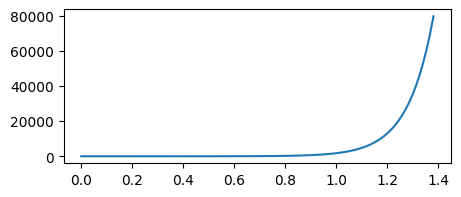

In [36]:
time, response = ctl.step_response(G)
plt.figure(figsize=(5, 2))
plt.plot(time, response)

- Encontrando as características da resposta transitória e permanente

In [37]:
def getOvershoot(time, response):
    peak_value = np.max(response)
    steady_state_value = response[-1]
    overshoot = (peak_value - steady_state_value) / steady_state_value
    return 'inf' if overshoot < 0 or overshoot > 999 else overshoot

def getZeta(overshoot):
    return -np.log(overshoot) / np.sqrt((np.pi**2 + np.log(overshoot)**2))

def getPeakTime(time, response):
    return time[response == max(response)][0] #time[np.argmax(response)]

def getError(response, setpoint=1):
    return abs(setpoint - abs(response[-1]))

def getSettlingTime(time, response, tolerance=0.02):
    steady_state_value = np.mean(response[-50:])
    settling_time = None
    
    if abs(steady_state_value) < 1e-6:
        lower_bound = -tolerance
        upper_bound = tolerance
    else:
        upper_bound = steady_state_value * (1 + tolerance)
        lower_bound = steady_state_value * (1 - tolerance)
    
    for i in range(len(time)):
        if lower_bound <= response[i] <= upper_bound:
            if settling_time is None:
                settling_time = time[i]
        else:
            settling_time = None
    
    return settling_time

def getAllInfo(time, response, show=True, setpoint=1):
    info = {
        'overshoot': getOvershoot(time, response),
        'peakValue': max(response),
        'peakTime': getPeakTime(time, response),
        'settlingTime': getSettlingTime(time, response),
        'finalValue': response[-1],
        'error': getError(response, setpoint)
    }

    if not show:
        return info

    print('overshoot: ', info['overshoot'])
    print('valor de pico: ', info['peakValue'])
    print('tempo de pico: ', info['peakTime'])
    print('tempo de assentamento: ', info['settlingTime'])
    print('valor final: ', info['finalValue'])
    print('erro: ', info['error'])


getAllInfo(time, response, setpoint=1)

overshoot:  0.0
valor de pico:  79999.76015999969
tempo de pico:  1.3815510557964275
tempo de assentamento:  None
valor final:  79999.76015999969
erro:  79998.76015999969


- Encontrando os polos do sistema

In [38]:
polos = ctl.pole(G)
zeros = ctl.zeros(G)

display(sp.Matrix(polos))
display(sp.Matrix(zeros))

Matrix([
[10.0],
[-5.0]])

Matrix(0, 1, [])

# REQUISITOS DO SISTEMA

### REQUISITOS NO TEMPO
- O primeiro parâmetero é que o erro seja nulo, ou seja $c(\infty) = \lim_{t \to \infty} c(t) = \lim_{s \to 0} s\,C(s) = \lim_{s \to 0} s\,G(s)R(s)= 0$

- O segundo parâmetro se refere à resposta transitória do sistema, ou seja, queremos alguma informação da resposta transitória que nos dê $\zeta$. Um bom parâmetro é o tempo de estabilização $T_s$, gostaria que $T_s$ fosse pequeno.


In [39]:
Ts = 5.0
UP = 0.5

In [40]:
zeta = -np.log(UP)/np.sqrt(np.pi**2 + np.log(UP)**2)
zeta

0.2154537619662468

In [41]:
Wn = 4/(zeta*Ts)
Wn

3.713093671232015

### ROOT LOCUS
Uma maneira de encontrar o polo desejado $s_D$ para o controlador é encontrando a interseção da linha vertical projetada por $\zeta$ com o caminho percorrido pelo LGR. O root locus nos dá uma informação importante sobre como é possível controlar o sistema, mostrando o caminho pelo qual os polos e zeros podem percorrer para chegar em uma estabilidade, ou seja, no semiplano esquerdo

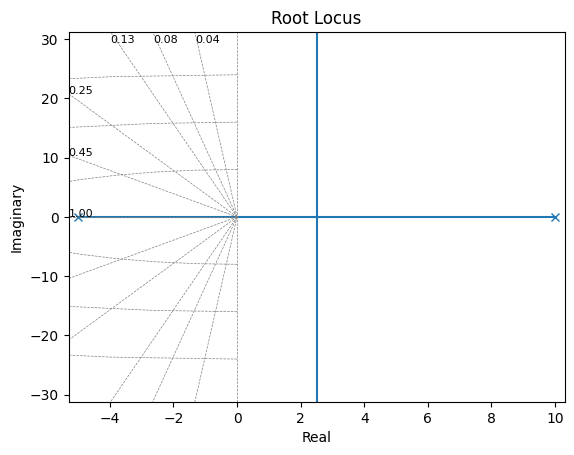

In [42]:
ctl.root_locus(G)
plt.show()

### POLO DESEJADO

$s = -\zeta\omega_n \pm \omega_n\sqrt{1-\zeta²}j$

In [43]:
s_desired = -zeta*Wn + Wn*np.sqrt(1-zeta**2)*sp.I
#s_desired = -0.2103+0.28046*sp.I
s_desired

-0.8 + 3.62588811346175*I

# CONTROLADOR
- Encontrando as constantes do controlador: $C(s) = K\frac{(s-a)(s-b)}{s(s+p)}$

- $p$ é um polo colocado arbitrariamente pois o número de polos tem que ser maior ou igual o número de zeros, para que seja possível implementá-lo digitalmente, com uma função de transferência própria. Esse polo $p$ precisa estar longe do eixo imaginário para que tenha pouca influência no sistema

In [44]:
s = sp.symbols('s')
K, a, b = sp.symbols('K a b', real=True)

### MALHA ABERTA
- A função de transferência final em malha aberta será $G(s)C(s)$

In [45]:
C     = K * ((s - a) * (s - b)) / (s * (s + 20))
C_bkp = str(C)

C

K*(-a + s)*(-b + s)/(s*(s + 20))

In [46]:
GC = sympyFunction(G) * C
GC

12*K*(-a + s)*(-b + s)/(s*(s + 20)*(s**2 - 5*s - 50))

In [47]:
ZERO = 1e-10

### POSIÇÃO DO ZERO
- a = s_desired

In [48]:
a_desired = float(sp.re(s_desired))
GC = GC.subs(a, a_desired)
GC

12*K*(-b + s)*(s + 0.8)/(s*(s + 20)*(s**2 - 5*s - 50))

In [49]:
a = a_desired
a

-0.8

### EQUAÇÃO 1 - SOMA DOS ÂNGULOS
- A soma dos angulos da função de transferência em malha aberta + 180º é igual a zero para o $s$ desejado

In [50]:
G_aux = GC.subs(K, 1).subs(s, s_desired)
angle = sp.arg(G_aux)
angle = roundSympyFunction(angle)

eq = sp.Eq(angle + sp.pi, ZERO)
eq

Eq(arg(-I*(0.8 + 3.625888*I)*(19.2 - 3.625888*I)*(-b - 0.8 + 3.625888*I)/(-46.0 - 18.129441*I + (-0.8 + 3.625888*I)**2)) + pi, 1.0e-10)

In [51]:
b_desired = sp.nsolve(eq, b, 0)
b_desired = float(b_desired)
b_desired

-4.377832058573486

In [52]:
GC = GC.subs(b, b_desired)
b  = b_desired

GC

12*K*(s + 0.8)*(s + 4.37783205857349)/(s*(s + 20)*(s**2 - 5*s - 50))

### EQUAÇÃO 3 - MÓDULO
- O módulo da função de transferência em malha aberta é igual a 1 para o $s$ desejado

In [53]:
G_aux  = GC.subs(s, s_desired)
modulo = sp.Abs(G_aux).expand().simplify()
modulo = roundSympyFunction(modulo)

eq = sp.Eq(modulo - 1, ZERO)
eq

Eq(0.048328*Abs(K) - 1, 1.0e-10)

In [54]:
K = sp.nsolve(eq, K, 0)
K = float(roundSympyFunction(K))
K

20.691945999860764

### CONTROLADOR
- Função de transferência do controlador $C(s)$

In [55]:
s = ctl.TransferFunction.s
C = K * ((s - a) * (s - b)) / (s * (s + 20))

print([K, a, b])
print(sympyFunction(C))
C

[20.691945999860764, -0.8, -4.377832058573486]
(20.6919459998608*s**2 + 107.13942135235*s + 72.4686916419695)/(s**2 + 20*s)


TransferFunction(array([ 20.691946  , 107.13942135,  72.46869164]), array([ 1, 20,  0]))

- Função de transferência do sistema em malha aberta $C(s)G(s)$

In [56]:
GC = G*C
GC

TransferFunction(array([ 248.303352  , 1285.67305623,  869.6242997 ]), array([    1,    15,  -150, -1000,     0]))

- Função de transferência em malha fechada com realimentação unitária $G_{feedback}(s) = \frac{G(s)C(s)}{1+G(s)C(s)}$

In [57]:
G_feedback = ctl.feedback(GC, 1)
G_feedback

TransferFunction(array([ 248.303352  , 1285.67305623,  869.6242997 ]), array([  1.        ,  15.        ,  98.303352  , 285.67305623,
       869.6242997 ]))

In [58]:
ctl.poles(G_feedback)

array([-6.69994712+4.26446404j, -6.69994712-4.26446404j,
       -0.80005288+3.62588947j, -0.80005288-3.62588947j])

# VERIFICANDO O LGR

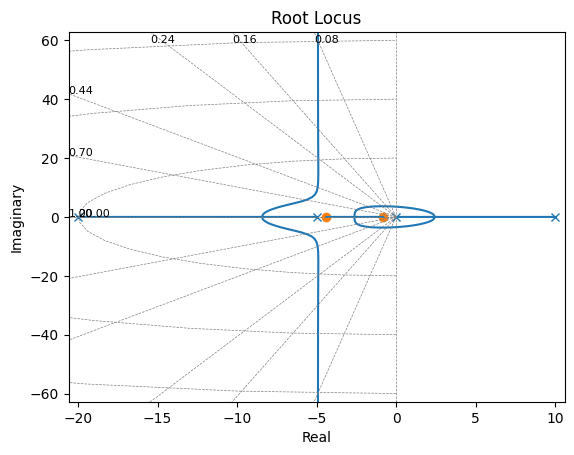

In [59]:
ctl.root_locus(GC)
plt.show()

# APLICANDO UM STEP

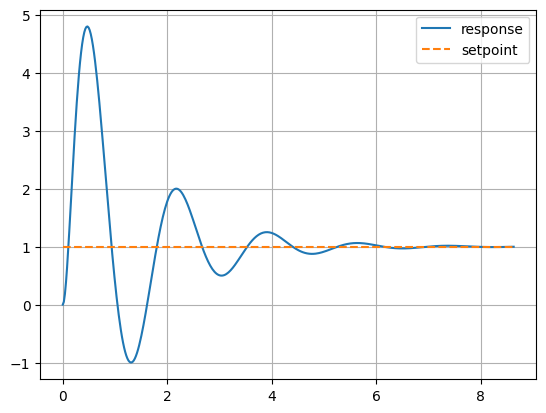

In [60]:
time, response = ctl.step_response(G_feedback)
plt.plot(time, response, label='response')
plt.plot(time, [1 for i in time], '--', label='setpoint')
plt.legend()
plt.grid()

In [61]:
getAllInfo(time, response, setpoint=1)

overshoot:  3.8044725259106102
valor de pico:  4.794728142635508
tempo de pico:  0.47394949338369263
tempo de assentamento:  6.738325405933369
valor final:  0.9979718099702828
erro:  0.002028190029717214


# APLICANDO VÁRIOS STEPS

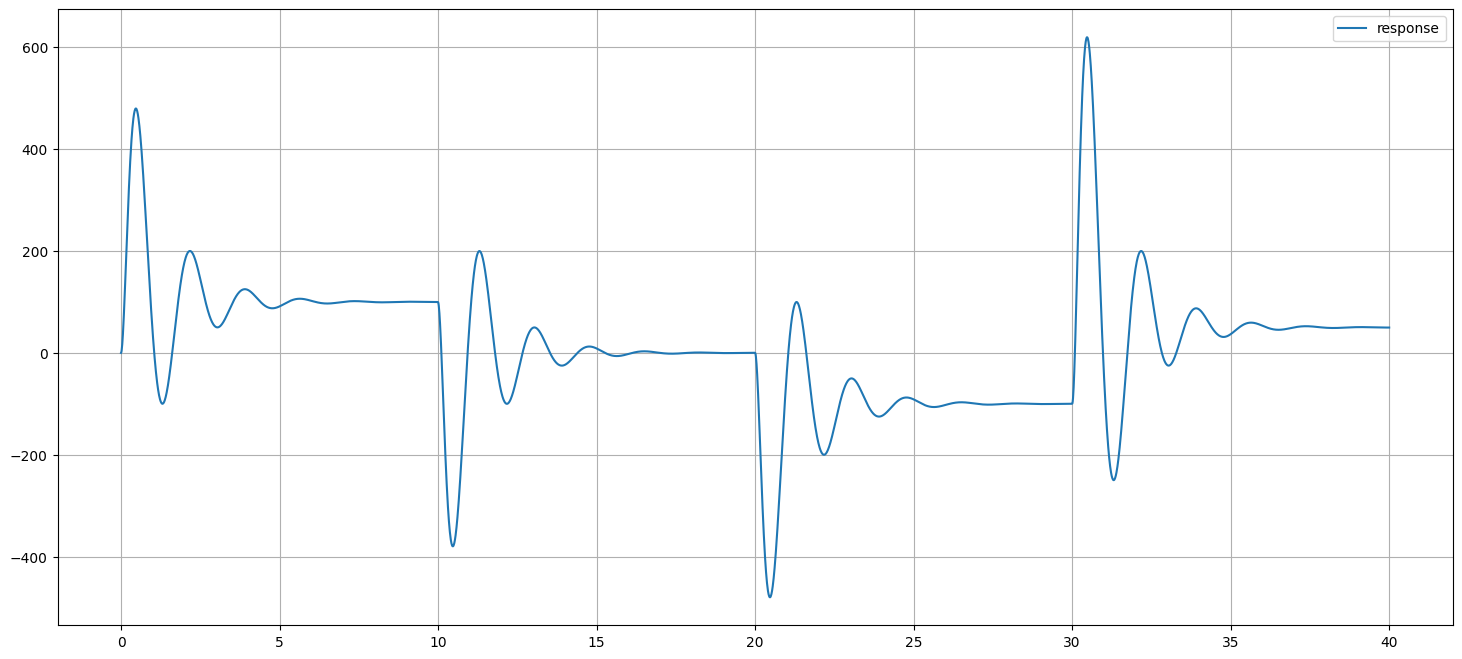

In [62]:
uData = [100 for i in range(1000)] + [0 for i in range(1000)] + [-100 for i in range(1000)] + [50 for i in range(1000)]
tData = np.linspace(0, 40, len(uData))

plt.figure(figsize=(18, 8))
time, response = ctl.forced_response(G_feedback, T=tData, U=uData)
plt.plot(time, response, label='response')
plt.legend()
plt.grid()